In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from   PIL import Image
from   torch.utils import data
from   torchvision import transforms
%matplotlib inline

##### 构造数据集

###### 类别编码

In [2]:
imgs_path       = glob.glob("./birds/*/*.jpg")                               # 获取所有图片的路径
all_label_names = [img_p.split("\\")[1].split(".")[1] for img_p in imgs_path]# 获取所有图片的类别名称
unique_labels   = np.unique(np.array(all_label_names))                       # 将所有的类别去重并用于计数
label_to_index  = dict((v,k) for k,v in enumerate(unique_labels))            # 将类别映射到数值
index_to_label  = dict((k,v) for k,v in enumerate(unique_labels))            # 将数值映射到类别
all_labels      = [label_to_index.get(name) for name in all_label_names]     # 将类别映射到数值 -- 制作数据集中的标签

###### 划分数据集

In [3]:
np.random.seed(2021)  # 设定为随机数种子
random_index = np.random.permutation(len(imgs_path))  # 返回乱序的图片下标
imgs_path    = np.array(imgs_path)[random_index]      # 对数据集进行乱序
all_labels   = np.array(all_labels)[random_index]     # 对数据集进行乱序
i            = int(len(imgs_path)*0.8)                # 设定切分数据集的位置

In [4]:
train_path   = imgs_path[:i]
train_lebels = all_labels[:i]
test_path    = imgs_path[i:]
test_labels  = all_labels[i:]

In [5]:
transform    = transforms.Compose([                   # 定义图形的转化模式
               transforms.Resize((224,224)),
               transforms.ToTensor()
])

In [6]:
class BirdsDataSet(data.Dataset):
    
    def __init__(self,img_path,labels):
        self.imgs   = img_path
        self.labels = labels
    
    def __getitem__(self,index):
        img     = self.imgs[index]
        label   = self.labels[index]
        # np_img[:,:,np.newaxis] 用来给HXW 增加一个维度2
        # np.repeat(XXX,time,axis) 表示沿axis将XXX重复time次，构造高维数组
        pil_img = Image.open(img)                                # 打开图片 H W C (彩色)  H W (黑白)
        np_img  = np.asarray(pil_img,dtype=np.uint8)             # 根据每张图像的具体模式，将其修改为 三通道图
        if len(np_img.shape) == 2:                               # 进行转换
            img_data = np.repeat(np_img[:,:,np.newaxis],3,axis=2)# *添加第三维 并将该维度重复三次 构造为三通道图像
            pil_img  = Image.fromarray(img_data)
        img_tensor = transform(pil_img)                          # 转换图像
        return img_tensor,label
        
    def __len__(self):
        return len(self.imgs)

In [7]:
train_ds = BirdsDataSet(train_path,train_lebels)
test_ds  = BirdsDataSet(test_path,test_labels)
train_dl = data.DataLoader(train_ds,batch_size=32)               # 这里不需要乱序
test_dl  = data.DataLoader(test_ds,batch_size=32)                # 这里不需要乱序

In [8]:
img_batch,label_batch = next(iter(test_dl))
img_batch.shape                                                  # 查看数据每一batch元素形状 

torch.Size([32, 3, 224, 224])

###### 数据可视化

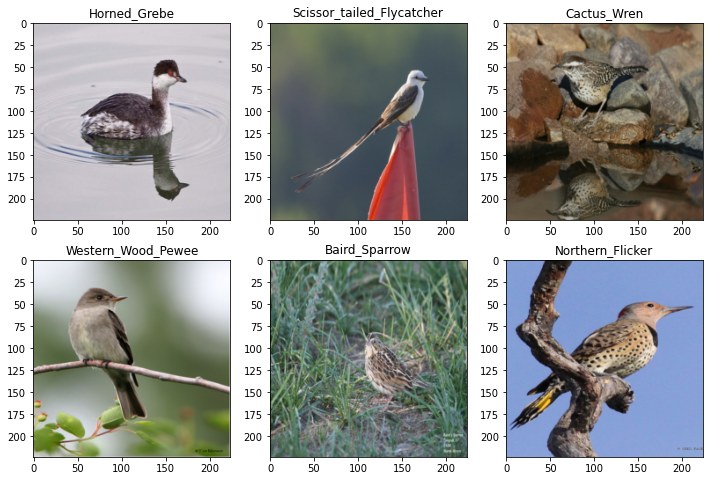

In [9]:
plt.figure(figsize=(12,8))
for i,(img,label) in enumerate(zip(img_batch[:6],label_batch[:6])):
    img = img.permute(1,2,0).numpy()
    plt.subplot(2,3,1+i)
    plt.title(index_to_label.get(label.item()))
    plt.imshow(img)

#### 使用DenseNet提取特征

###### 导入DenseNet的卷积部分

In [10]:
my_densenet = torchvision.models.densenet121(pretrained=True).features # 得到卷积基的部分

###### 将模型迁移至GPU

In [11]:
if torch.cuda.is_available():
    my_densenet = my_densenet.to("cuda")

###### 冻结卷积基

In [12]:
for p in my_densenet.parameters():
    p.requires_grad = False

###### 卷积层特征提取

In [13]:
train_features          = []
train_features_lebels   = []
for im,la in train_dl:
    out = my_densenet(im.cuda())
    out = out.view(out.size(0),-1)
    train_features.extend(out.cpu().data)         # 提取图像的特征
    train_features_lebels.extend(la)              # 提取对应图像的标签

test_features           = []
test_features_lebels    = []
for im,la in test_dl:
    out = my_densenet(im.cuda())
    out = out.view(out.size(0),-1)
    test_features.extend(out.cpu().data)          # 提取图像的特征
    test_features_lebels.extend(la)               # 提取对应图像的标签

###### 查看特征信息

In [14]:
len(train_features)                               # 训练数据集中一共有9430个图像数据

9430

In [15]:
len(train_features[0])                            # 每一张图片对应50176个特征

50176

###### 根据提取到的特征重新构建数据集

In [16]:
class FeatureDataset(data.Dataset):
    def __init__(self,feature_list,label_list):   # 根据特征列表 标签列表 构造数据集
        self.feat_list  = feature_list
        self.label_list = label_list
    
    def __getitem__(self,index):
        return self.feat_list[index],self.label_list[index]
    
    def __len__(self):
        return len(self.feat_list)

train_features_ds = FeatureDataset(train_features,train_features_lebels)
test_features_ds  = FeatureDataset(test_features , test_features_lebels)

train_features_dl = data.DataLoader(train_features_ds,batch_size=32,shuffle=True)
test_features_dl  = data.DataLoader(test_features_ds ,batch_size=32)

##### 构造模型

In [17]:
in_feature_size = test_features[0].shape[0]   # 设定第一线性层输入大小

In [18]:
class FCModel(nn.Module):                     # FC = Fully connect
    
    def __init__(self,in_size,out_size):
        super().__init__()
        self.linear = torch.nn.Linear(in_size,out_size)
    
    def forward(self,input):
        return self.linear(input)

In [19]:
net = FCModel(in_feature_size,200)            # 构建200分类模型实例对象

In [20]:
net = net.to("cuda")

##### target :实现并训练模型 解决基于bird数据集的200分类问题

In [21]:
loss_fn  =  torch.nn.CrossEntropyLoss()
optim    =  torch.optim.Adam(net.parameters(),lr=0.00001)
epoches  =  100

In [22]:
from torch.optim import lr_scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optim, step_size=7, gamma=0.1) 

In [23]:
def fit(model,trainloader,testloader,epoch):
    correct = 0       # 记录正确率
    total   = 0       # 记录训练样本总数量
    running_loss = 0
    
    model.train()     # 设置为训练模式 表示DropOut会起作用
    
    for x,y in trainloader:
        y      = torch.tensor(y,dtype=torch.long)
        x,y    = x.to("cuda"),y.to("cuda")
        y_pred = net(x)
        loss   = loss_fn(y_pred,y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred,dim=1)
            correct+=(y_pred == y).sum().item()
            total  += y.size(0)
            running_loss += loss.item()
    
    exp_lr_scheduler.step()
    epoch_loss = running_loss / len(trainloader.dataset) # 得到每一个样本在本epoch下的平均loss
    epoch_acc  = correct / total                         # 得到整个样本的平均预测正确率
    
    test_correct      = 0        # 记录正确率
    test_total        = 0        # 记录训练样本总数量
    test_running_loss = 0
    
    model.eval()                 # 将模型修改为预测模式 表示DropOut失效 注意在验证数据集上不需要进行Dropout
    
    with torch.no_grad():
        for x,y in testloader:
            y      = torch.tensor(y,dtype=torch.long)
            x,y    = x.to("cuda"),y.to("cuda")
            y_pred = net(x)
            loss   = loss_fn(y_pred,y)
            y_pred = torch.argmax(y_pred,dim=1)
            test_correct+=(y_pred == y).sum().item()
            test_total  += y.size(0)
            test_running_loss += loss.item()
    
    epoch_test_loss = test_running_loss / len(testloader.dataset) # 得到每一个样本在本epoch下的平均loss
    epoch_test_acc  = test_correct / test_total                   # 得到整个样本的平均预测正确率
    
    print(
            "epoch:","\t",epoch,"\t",
            "loss: ","\t",round(epoch_loss,3),"\t",
            "accuracy: ","\t",round(epoch_acc,3),"\t",
            "test_loss: ","\t",round(epoch_test_loss,3),"\t",
            "test_accuracy: ","\t",round(epoch_test_acc,3),"\t"
        )
    return epoch_loss,epoch_acc,epoch_test_loss,epoch_test_acc

In [24]:
train_loss = []
train_acc  = []
test_loss  = []
test_acc   = []

In [25]:
for epoch in range(epoches):
    epoch_loss,epoch_acc,epoch_test_loss,epoch_test_acc = fit(net,train_features_dl,test_features_dl,epoch)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

C:\Users\20613\AppData\Local\Temp/ipykernel_10888/260720630.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y      = torch.tensor(y,dtype=torch.long)
C:\Users\20613\AppData\Local\Temp/ipykernel_10888/260720630.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y      = torch.tensor(y,dtype=torch.long)


epoch: 	 0 	 loss:  	 0.129 	 accuracy:  	 0.176 	 test_loss:  	 0.095 	 test_accuracy:  	 0.362 	
epoch: 	 1 	 loss:  	 0.058 	 accuracy:  	 0.698 	 test_loss:  	 0.07 	 test_accuracy:  	 0.515 	
epoch: 	 2 	 loss:  	 0.03 	 accuracy:  	 0.899 	 test_loss:  	 0.06 	 test_accuracy:  	 0.566 	
epoch: 	 3 	 loss:  	 0.017 	 accuracy:  	 0.967 	 test_loss:  	 0.055 	 test_accuracy:  	 0.592 	
epoch: 	 4 	 loss:  	 0.01 	 accuracy:  	 0.99 	 test_loss:  	 0.052 	 test_accuracy:  	 0.595 	
epoch: 	 5 	 loss:  	 0.006 	 accuracy:  	 0.998 	 test_loss:  	 0.05 	 test_accuracy:  	 0.61 	
epoch: 	 6 	 loss:  	 0.004 	 accuracy:  	 0.999 	 test_loss:  	 0.049 	 test_accuracy:  	 0.617 	
epoch: 	 7 	 loss:  	 0.003 	 accuracy:  	 1.0 	 test_loss:  	 0.049 	 test_accuracy:  	 0.617 	
epoch: 	 8 	 loss:  	 0.003 	 accuracy:  	 1.0 	 test_loss:  	 0.048 	 test_accuracy:  	 0.617 	
epoch: 	 9 	 loss:  	 0.003 	 accuracy:  	 1.0 	 test_loss:  	 0.048 	 test_accuracy:  	 0.618 	
epoch: 	 10 	 loss:  	 

epoch: 	 84 	 loss:  	 0.002 	 accuracy:  	 1.0 	 test_loss:  	 0.047 	 test_accuracy:  	 0.619 	
epoch: 	 85 	 loss:  	 0.002 	 accuracy:  	 1.0 	 test_loss:  	 0.047 	 test_accuracy:  	 0.619 	
epoch: 	 86 	 loss:  	 0.002 	 accuracy:  	 1.0 	 test_loss:  	 0.047 	 test_accuracy:  	 0.619 	
epoch: 	 87 	 loss:  	 0.002 	 accuracy:  	 1.0 	 test_loss:  	 0.047 	 test_accuracy:  	 0.619 	
epoch: 	 88 	 loss:  	 0.002 	 accuracy:  	 1.0 	 test_loss:  	 0.047 	 test_accuracy:  	 0.619 	
epoch: 	 89 	 loss:  	 0.002 	 accuracy:  	 1.0 	 test_loss:  	 0.047 	 test_accuracy:  	 0.619 	
epoch: 	 90 	 loss:  	 0.002 	 accuracy:  	 1.0 	 test_loss:  	 0.047 	 test_accuracy:  	 0.619 	
epoch: 	 91 	 loss:  	 0.002 	 accuracy:  	 1.0 	 test_loss:  	 0.047 	 test_accuracy:  	 0.619 	
epoch: 	 92 	 loss:  	 0.002 	 accuracy:  	 1.0 	 test_loss:  	 0.047 	 test_accuracy:  	 0.619 	
epoch: 	 93 	 loss:  	 0.002 	 accuracy:  	 1.0 	 test_loss:  	 0.047 	 test_accuracy:  	 0.619 	
epoch: 	 94 	 loss: 

#### 模型测试

In [26]:
import random
r_index = random.choice(range(len(test_features_ds)))     # 随机生成一个数字进行测试数据的随机选取
img_tensor, real_label = test_features_ds[r_index]        # 从测试数据集中找到指定的数据条目
pred = net.forward(img_tensor.cuda())                     # 得到预测结果向量
print(torch.argmax(pred))                                 # 根据预测结果向量得到最终预测结果
real_label                                                # 打印真实标签并进行比较

tensor(125, device='cuda:0')


tensor(125, dtype=torch.int32)